# Correlate PCA Models
This workflow makes pairwise comparisons between all PCA models to determine trends in similarity across models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from util_functions import load_file, pickle_file, starting_run, finished_run

### Notebook Parameters

In [2]:
model_df = load_file('data_meta_pickled/pca_models_pickled_df.pickle')
geo_df=pd.DataFrame(load_file('data_synthesized_pickled/geo_plotting_data.pickle')).loc[:,['subject', 'stimulus', 'bin_scores', 'save_path']]
# geo_corr_df = pd.DataFrame(columns=['subject_1', 'stimulus_1', 'component_1', 'subject_2', 'stimulus_2', 'component_1', 'geo_corr'])

### Notebook Functions

In [3]:
def create_component_list():
    comp_list = []
    for row in geo_df.itertuples():
        bin_list = row.bin_scores.index
        bin_data = row.bin_scores.values.T
        num_components = bin_data.shape[0]
        for comp in range(num_components):
            comp_list.append([
                row.subject,
                row.stimulus,
                comp,
                pd.Series(bin_data[comp], index=bin_list)
            ])
    return comp_list

In [4]:
def fill_comparison_df(comp_list):
    comp_list_1 = np.tile(comp_list, (len(comp_list),1))
    comp_list_2 = np.repeat(comp_list, len(comp_list), axis=0)
    df_1 = pd.DataFrame(comp_list_1, columns=['subject', 'stimulus', 'component', 'values']).add_suffix('_1')
    df_2 = pd.DataFrame(comp_list_2, columns=['subject', 'stimulus', 'component', 'values']).add_suffix('_2')
    return pd.concat([df_1, df_2], axis=1)

In [5]:
def correlate_component_geographies(value_1, value_2):
    df = pd.DataFrame({
        'comp_1': value_1,
        'comp_2': value_2,
    })
    df['comp_1'].fillna(df['comp_2'].min(), inplace=True)
    df['comp_2'].fillna(df['comp_1'].min(), inplace=True)
    return pearsonr(df['comp_1'], df['comp_2'])[0]

In [6]:
def create_component_function_df():
    component_data_list = []
    for row in model_df.itertuples():
        model = load_file(row.model_path)
        file = load_file(row.orig_data_path)
        component_functions = model.transform(file).T
        for component in range(len(component_functions)):
            component_data_list.append([
                row.subject,
                row.stimulus,
                component,
                component_functions[component]
            ])
    component_data_df = pd.DataFrame(component_data_list, columns=['subject', 'stimulus', 'component', 'values'])
    component_data_df.set_index(['subject', 'stimulus', 'component'], inplace=True)
    return component_data_df

In [7]:
def equalize_component_function_lengths(comp_1, comp_2):
    if comp_1.size == comp_2.size:
        return comp_1, comp_2
    elif comp_1.size > comp_2.size:
        return equalize_component_function_lengths(comp_2, comp_1)
    while comp_1.size < comp_2.size:
        comp_1 = np.concatenate((comp_1, comp_1), axis=None)
    comp_1 = comp_1[0:comp_2.size]
    return comp_1, comp_2

In [8]:
def correlate_component_functions(row, comp_data_df):
    comp1=comp_data_df.at[(row.subject_1, row.stimulus_1, row.component_1), 'values']
    comp2=comp_data_df.at[(row.subject_2, row.stimulus_2, row.component_2), 'values']
    comp1, comp2 = equalize_component_function_lengths(comp1, comp2)
    return pearsonr(comp1, comp2)[0]

In [9]:
def apply_correlation_functions(comp_df, component_data_df):
    geo_corr = []
    func_corr = []
    for row in comp_df.itertuples():
        geo_corr.append(correlate_component_geographies(row.values_1, row.values_2))
        func_corr.append(correlate_component_functions(row, component_data_df))
    geo_corr = pd.Series(geo_corr)
    func_corr = pd.Series(func_corr)
    comp_df['geo_corr'] = geo_corr
    comp_df['func_corr'] = func_corr
    return comp_df

### Correlate Geographies
This workflow determines "geographical" correlations for each pairwise component comparison by comparing the differential in the loadings of each component on each standardized geographical bin created in Workflow 04.

In [10]:
print(starting_run("Correlating Components"))
comp_list = create_component_list()
comp_df = fill_comparison_df(comp_list)
component_data_df = create_component_function_df()
correlation_df = apply_correlation_functions(comp_df, component_data_df)
# print(comp_df.loc[0:1000].apply(apply_correlation_functions, axis=1))
print(finished_run("Correlating Components"))

Starting Correlating Components 00:02:05.985454
None
Finished Correlating Components 11:55:53.761382
None


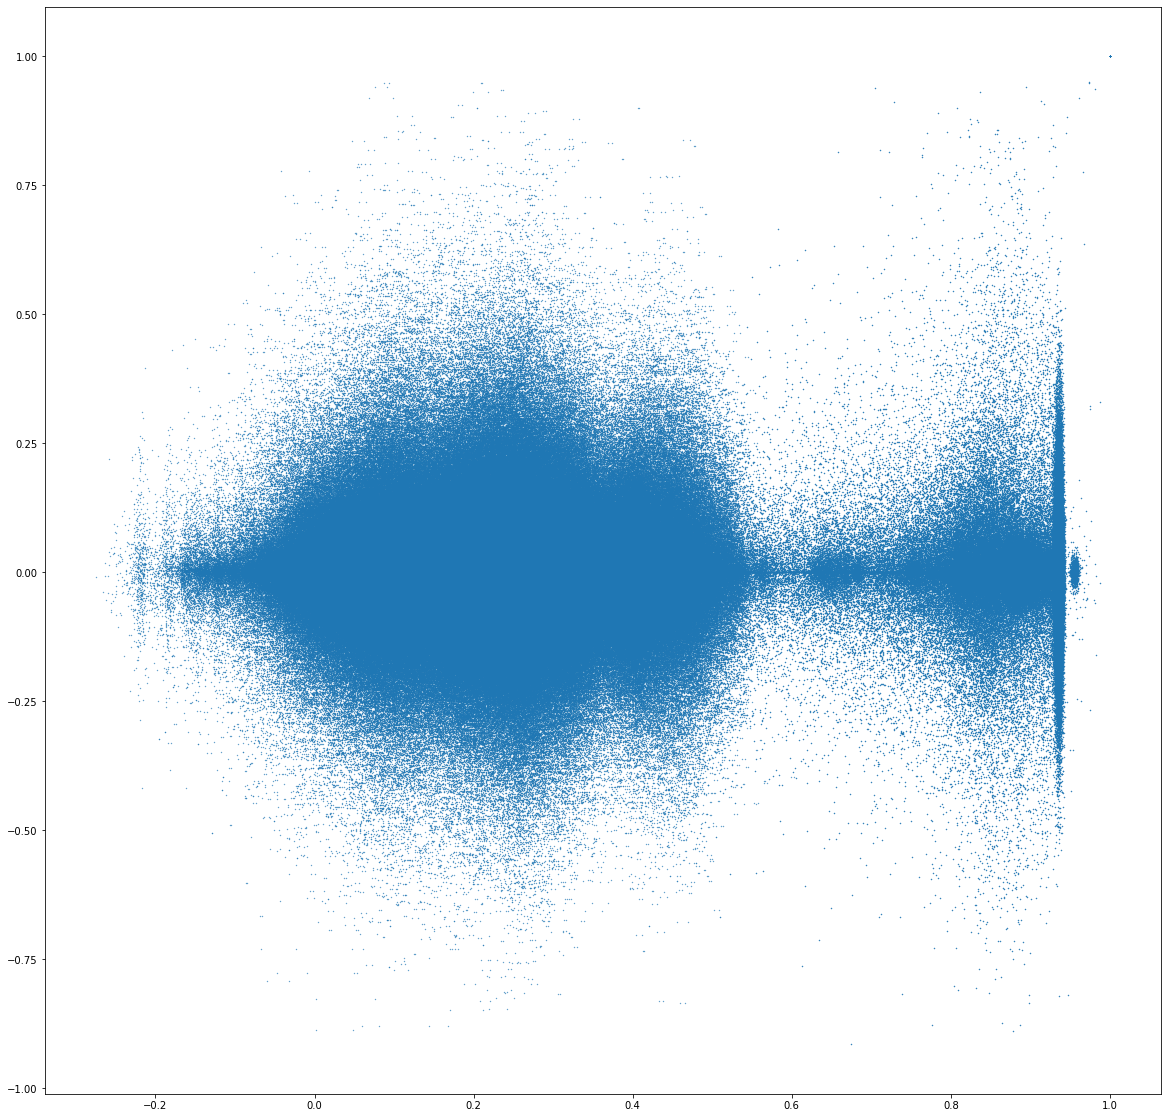

In [14]:
fig = plt.figure(figsize=(20,20))
plt.scatter(correlation_df.geo_corr, correlation_df.func_corr, s=.1)
plt.show()

In [15]:
del correlation_df['values_1']
del correlation_df['values_2']

In [16]:
pickle_file('results/component_correlations_df.pickle', correlation_df)